<a href="https://colab.research.google.com/github/mahamapara/CS152_BDL/blob/main/HW1_MahaMapara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 1 Maha Mapara

For the original HW1 Instructions see:

https://www.cs.tufts.edu/cs/152BDL/2022f/hw1.html

# Collaboration statement

> At the top of your writeup, you must include the names of any people you worked with, and in what way you worked them (discussed ideas, debugged math, team coding). We may occasionally check in with groups to ascertain that everyone in the group was participating in accordance with this policy.

I went to Mike's office hours (questions regarding 2b,c,e,g were discussed)

I collaborated with Tina on errors in matern kernel function, understanding calculations of posterior distribution and CI (2a, 2c, 2g)

# Imports

In [72]:
import numpy as np
import pandas as pd

import scipy.stats
from scipy.stats import multivariate_normal
from scipy.special import kv as scipy_bessel_func
from scipy.special import gamma as scipy_gamma_func

In [73]:
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns
sns.set('notebook', font_scale=1.5, style='whitegrid')

# Problem 1: Sample from GP prior

## Write code to sample f values from prior

In [74]:
def draw_sample_of_f_from_GP_prior_at_x_grid(
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP prior given mean/cov functions

    Args
    ----
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value 
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    kernel_kwargs : dict
        Each key,val pair provides the name and float value of
        the named hyperparameter for kernel function
    random_seed : int
        See for the random number generator
    n_samples : int
        Number of samples to draw from the prior    

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    S = int(n_samples)
    G = x_grid_G.size
    mean_G =  mean_func(x_grid_G) 
    cov_GG = cov_func(x_grid_G, **kernel_kwargs) 
    assert cov_GG.shape == (G,G)
    
    # Use consistent random number generator for reproducibility
    prng = np.random.RandomState(int(random_seed))
    f_SG = prng.multivariate_normal(mean_G,cov_GG,size=S)
    return f_SG

get current axis handle

In [75]:
def plot_f_samples_at_x_grid(x_grid_G, f_grid_SG,
                             color=None, axis_handle=None):
    if axis_handle is None:
        axis_handle = pylab.gca() # get current axis handle if not provided
    S, G = f_grid_SG.shape
    for s in range(S):
        axis_handle.plot(x_grid_G, f_grid_SG[s], '-', color=color)

### Define mean_func

In [76]:
def mean_func(x_grid_G):
    return np.zeros_like(x_grid_G)

### Define sqexp kernel

In [77]:
def sqexp_kernel_func(x_grid_A, x_grid_B=None, **kernel_kwargs):
    ''' Compute squared exponential kernel between two provided arrays
    
    Args
    ----
    x_A : 1D array, shape (A,)
        Contains univariate x value for each of A observations
    x_B : 1D array, shape (B,)
        Contains univariate x value for each of B observations
    kernel_kwargs : dict
        Contains length scale value under key 'L'
    
    Returns
    -------
    k_AB : 2D array, shape (A,B)
        Kernel matrix where k_AB[aa, bb]
        gives the kernel value between x_grid_A[aa], x_grid_B[bb]
    '''
    # Handy code to reshape provided 1D arrays into 2D for efficient vector ops
    if x_grid_B is None:
        x_grid_B = x_grid_A.copy()
    A = x_grid_A.shape[0]
    B = x_grid_B.shape[0]
    xa_A1 = np.reshape(x_grid_A, (A, 1))
    xb_1B = np.reshape(x_grid_B, (1, B))
    
    # Pull desired lengthscale value out of dict
    L = kernel_kwargs['L']

    #calc square exponential
    val = np.exp(-(np.square(xa_A1 - xb_1B))/(2*np.square(L)))
    
    return val

### Define Matern kernel

In [78]:
def matern_kernel_func(x_grid_A, x_grid_B=None, **kernel_kwargs):
    ''' Compute Matern kernel between two provided arrays
    
    Args
    ----
    x_A : 1D array, shape (A,)
        Contains univariate x value for each of A observations
    x_B : 1D array, shape (B,)
        Contains univariate x value for each of B observations
    kernel_kwargs : dict
        Contains length scale value under key 'L'
        Contains smoothness value under key 'nu'
    
    Returns
    -------
    k_AB : 2D array, shape (A,B)
        Kernel matrix where k_AB[aa, bb]
        gives the kernel value between x_grid_A[aa], x_grid_B[bb]
    '''
    # Handy code to reshape provided 1D arrays into 2D for efficient vector ops
    if x_grid_B is None:
        x_grid_B = x_grid_A.copy()
    A = x_grid_A.shape[0]
    B = x_grid_B.shape[0]
    xa_A1 = np.reshape(x_grid_A, (A, 1))
    xb_1B = np.reshape(x_grid_B, (1, B))
    
    # Pull desired lengthscale value out of dict
    L = kernel_kwargs['L']
    nu = kernel_kwargs['nu']
    
    k_AB = ((2**(1-nu))/scipy_gamma_func(nu))*(((np.sqrt(2*nu)*abs(xa_A1-xb_1B))/L)**nu)*(scipy_bessel_func(nu, ((np.sqrt(2*nu)*abs(xa_A1-xb_1B))/L)))

    #k_AB = k_AB[~pd.isna(k_AB)]
    k_AB = np.nan_to_num(k_AB, nan = 1) 

    k_AB[k_AB == inf] = 10**-5

    return k_AB

In [79]:
k_AB = np.array([2, 3, inf])
k_AB
# k_AB[k_AB == inf] = 1
k_AB

array([ 2.,  3., inf])

### Setup plot appearance properties

In [80]:
H = 4 # Panel height
W = 6 # Panel width

S = 3  # num samples to draw from posterior

G = 501  # num grid points to use
x_grid_G = np.linspace(-6, 6, G)



## Part a: Plots of samples with Squared Exponential Kernel

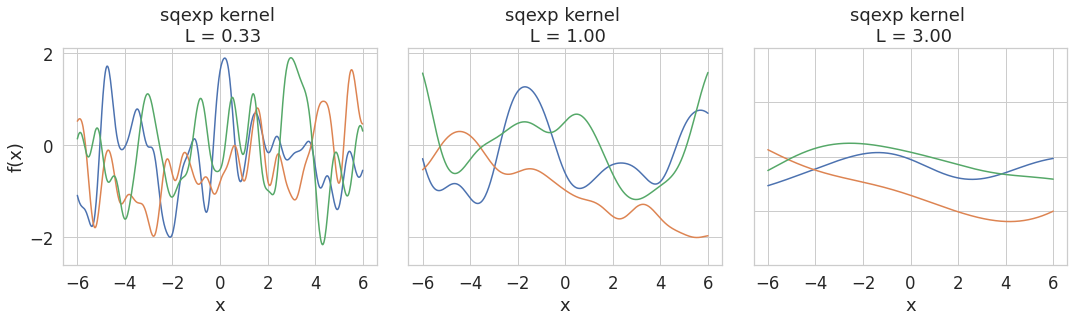

In [81]:
ell_list = [0.33, 1.0, 3.0]
ncols = len(ell_list)
nrows = 1

fig_h, axes_list = plt.subplots(
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
    figsize=(W*ncols, H*nrows))

for ii, L in enumerate(ell_list):
    cur_ax_h = axes_list[ii]
    
    f_grid_SG = draw_sample_of_f_from_GP_prior_at_x_grid(
        x_grid_G, mean_func, sqexp_kernel_func,
        kernel_kwargs=dict(L=L), n_samples=S)
    assert f_grid_SG.shape == (S, G)
    
    plot_f_samples_at_x_grid(
        x_grid_G,
        f_grid_SG,
        axis_handle=cur_ax_h,
        )
    cur_ax_h.set_title('sqexp kernel \n L = %.2f' % L)
    cur_ax_h.set_yticks([-4, -2, 0, 2, 4]);
    cur_ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
    cur_ax_h.set_xlabel('x');
    if ii == 0: cur_ax_h.set_ylabel('f(x)');
    
plt.subplots_adjust(hspace=0, wspace=0.1)

## Part 1b: Short answer interpreting SqExp Plots

As L increases, the samples become smoother. For L = 0.33, the 3 samples have high variability but as L increases, the variability decreases. This is because L determines the length of "wiggles", a larger L means lengthing out the "wiggles".

## Part 1c: Plots of samples with Matern Kernel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel

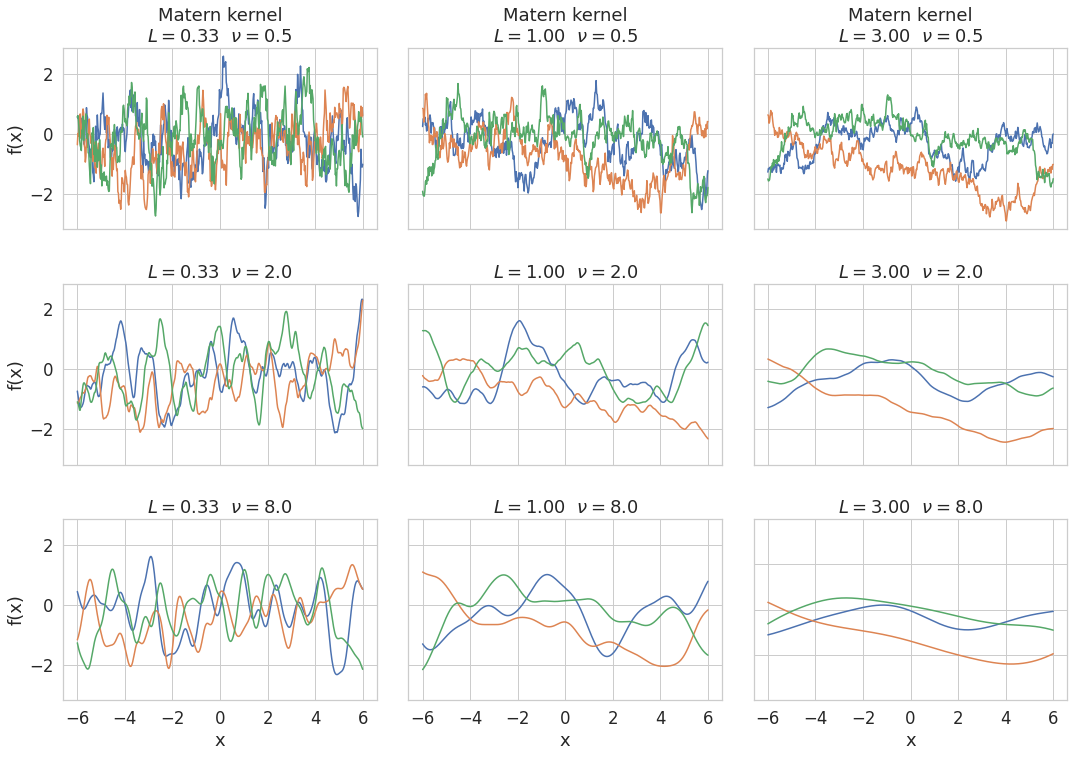

In [82]:
ell_list = [0.33, 1.0, 3.0]
ncols = len(ell_list)

nu_list = [0.5, 2.0, 8.0]
nrows = len(nu_list)

fig_h, axes_grid_RC = plt.subplots(
    nrows=nrows, ncols=ncols,
    sharex=True, sharey=True,
    figsize=(W*ncols, H*nrows))
for cc, L in enumerate(ell_list):
    for rr, nu in enumerate(nu_list):
        cur_ax_h = axes_grid_RC[rr,cc]

        f_grid_SG = draw_sample_of_f_from_GP_prior_at_x_grid(
            x_grid_G, mean_func, matern_kernel_func,
            kernel_kwargs=dict(L=L, nu=nu),
            n_samples=S)
        assert f_grid_SG.shape == (S, G)
        
        plot_f_samples_at_x_grid(
            x_grid_G,
            f_grid_SG,
            axis_handle=cur_ax_h
            )
        
        # Make plot look pretty. Please don't edit without good reasons.
        title_str = r'$L{=}%.2f~~\nu{=}%.1f$' % (L,nu)
        if rr == 0:
            title_str = 'Matern kernel\n' + title_str
        cur_ax_h.set_title(title_str)
        cur_ax_h.set_yticks([-4, -2, 0, 2, 4]);
        cur_ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
        if rr == len(nu_list) - 1: cur_ax_h.set_xlabel('x');
        if cc == 0: cur_ax_h.set_ylabel('f(x)');
            
plt.subplots_adjust(hspace=0.3, wspace=0.1)

## Part 1d: Short answer interpreting Matern plots

As L increases, length of "wiggles" in the samples increases, which means there's less change in the value of f(x) for each change in x, as the "wiggles" lengthen.

As $\nu$ increases, the smoothness of the samples increase which means that differentiability increases. 

# Problem 2: Sampling from GP posterior given data

## Implementing the posterior

In [83]:
def calc_posterior_params__mean_G_and_cov_GG(
        x_train_N,
        y_train_N,
        x_test_G,
        mean_func=None,
        cov_func=None,
        sigma=0.1,
        **kernel_kwargs):
    """ Compute parameters of Gaussian posterior over function value at G provided inputs
    
    Args
    ----
    x_train_N : 1D array, size n_train_pts (N)
    y_train_N : 1D array, size n_train_pts (N)
    x_grid_G : 1D array, size n_grid_pts (G)
    
    Returns
    -------
    mean_G : 1D array, size G
        Posterior mean vector
    cov_GG : 2D array, size G x G
        Posterior covariance matrix
    
    References
    ----------
    Alg. 2.1 of GPML book by Rasmussen and Williams
    http://www.gaussianprocess.org/gpml/chapters/RW2.pdf#page=13
    """
    N = x_train_N.shape[0]
    G = x_test_G.shape[0]

    #matrices needed
    sigma_N = (sigma**2)*np.identity(N)

    K__N_G = cov_func(x_train_N, x_test_G, **kernel_kwargs)

    K__N_N = cov_func(x_train_N, x_train_N, **kernel_kwargs) #
    K__G_G = cov_func(x_test_G, x_test_G, **kernel_kwargs) #

    ####calc mean_G

    #cholesky decomposition
    L = np.linalg.cholesky(K__N_N + sigma_N)
    #alpha
    alpha = np.linalg.lstsq(L.T, np.linalg.lstsq(L, y_train_N)[0], rcond=None)[0] #left matrix div: [0] returns only the result and not rank, s
    #mean
    mean_G = K__N_G.T @ alpha

    ####calc cov_GG
    #cholesky decomposition
    # L = np.linalg.cholesky(K__N_N + sigma_N)
    #v
    div_val = np.linalg.lstsq(L, K__N_G, rcond=None)[0] #left matrix div
    v = div_val[0]
    #cov
    cov_GG = (K__G_G - (v.T @ v)) 
    cov_GG = np.nan_to_num(cov_GG, nan = 1)
    cov_GG[np.where(cov_GG==0)]=10**-12
    
    return mean_G, cov_GG

In [84]:
def draw_sample_of_f_from_GP_posterior_at_x_grid(
        x_train_N, y_train_N,
        x_grid_G, mean_func, cov_func,
        kernel_kwargs={},
        sigma=0.1,
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP posterior given data and mean/cov functions

    Args
    ----
    x_train_N : 1D array, size n_train_pts (N)
        Contains observed inputs of each of the N training points
    y_train_N : 1D array, size n_train_pts (N)
        Contains observed outputs of each of the N training points
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value 
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    sigma : scalar float
        Standard deviation of the likelihood of observations y given f
    random_seed : int
        Seed for the random number generator
    n_samples : int
        Number of samples to draw from the prior

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    mean_G, cov_GG = calc_posterior_params__mean_G_and_cov_GG(
        x_train_N, y_train_N, x_grid_G, mean_func, cov_func, sigma, **kernel_kwargs)

    prng = np.random.RandomState(int(random_seed))
    f_SG = prng.multivariate_normal(mean_G,cov_GG,size=S)
    return f_SG

## Load training data

In [85]:
url = 'https://raw.githubusercontent.com/tufts-ml-courses/cs152BDL-22f-assignments/main/hw1/avg_deaths_per_day_in_middlesex_ma_2021__train.csv'
train_csv_df = pd.read_csv(url)

In [86]:
x_train_N = np.asarray(train_csv_df['days_since_211207'].values, dtype=np.float64)
y_train_N = np.asarray(train_csv_df['deaths_avg'].values, dtype=np.float64)

N = y_train_N.size

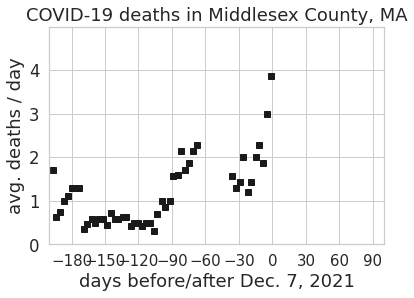

In [87]:
plt.subplots(nrows=1,ncols=1,figsize=(W,H));
plt.plot(x_train_N, y_train_N, 'ks');
plt.ylim([0, 4.99]);
plt.xlim([-200, 100]);
plt.xticks(np.arange(-180, 91, 30), fontsize=15);
plt.xlabel('days before/after Dec. 7, 2021');
plt.ylabel('avg. deaths / day');
plt.title('COVID-19 deaths in Middlesex County, MA');

## Problem 2a: Plots of posterior samples with SqExp kernel

We'll draw a vertical red line at $x'=20$, which a few later questions ask about.

In [88]:
url_test = 'https://raw.githubusercontent.com/tufts-ml-courses/cs152BDL-22f-assignments/main/hw1/avg_deaths_per_day_in_middlesex_ma_2021__test.csv'
test_csv_df = pd.read_csv(url_test)
x_test_G = np.asarray(test_csv_df['days_since_211207'].values, dtype=np.float64)

G = 501
x_grid_G = np.linspace(-200, 150, G)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4

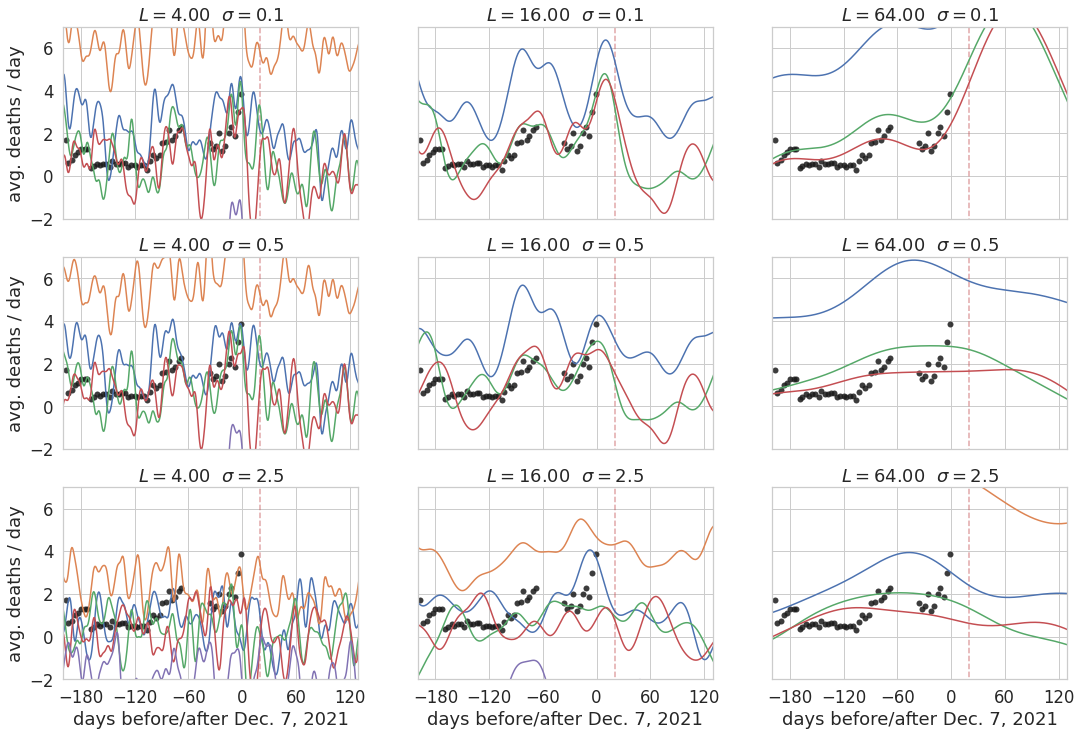

In [89]:
n_samples = 5
S = 5

ell_list = [4.0, 16.0, 64.]
ncols = len(ell_list)

sigma_list = [0.1, 0.5, 2.5]
nrows = len(sigma_list)

fig_h, ax_grid_RC = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True,
    figsize=(ncols*W,nrows*H))
for cc, L in enumerate(ell_list):
    for rr, sigma in enumerate(sigma_list):
        f_grid_SG = draw_sample_of_f_from_GP_posterior_at_x_grid(
            x_train_N, y_train_N,
            x_grid_G,
            mean_func, sqexp_kernel_func,
            sigma=sigma,
            kernel_kwargs=dict(L=L),
            n_samples=n_samples)
        
        # Show the training data as dark (but not too dark) dots
        cur_ax_h = ax_grid_RC[rr,cc]
        cur_ax_h.plot(
            x_train_N, y_train_N, 'k.',
            markersize=12, mew=0, alpha=0.85)
        
        # Show a vertical line at x=+20, which we'll ask about later
        x_20_H = [20, 20]
        y_20_H = [-3, 10]
        cur_ax_h.plot(
            x_20_H, y_20_H, 'r--', alpha=0.5)
        
        # Show the 5 samples from the posterior
        plot_f_samples_at_x_grid(
            x_grid_G,
            f_grid_SG,
            axis_handle=cur_ax_h
            )
        
        title_str = r'$L{=}%.2f~~\sigma{=}%.1f$' % (L, sigma)
        cur_ax_h.set_title(title_str)
        
        # Make the plot look pretty. Please don't adjust!
        cur_ax_h.set_ylim([-2, 6.99]);
        cur_ax_h.set_xlim([-200, 130]);
        cur_ax_h.set_xticks(np.arange(-180, 121, 60));
        if rr == 2:
            cur_ax_h.set_xlabel('days before/after Dec. 7, 2021');
        if cc == 0:
            cur_ax_h.set_ylabel('avg. deaths / day');

## Problem 2b: Provide the numerical values of the posterior mean/variance at f(20) for 3 settings

**Hint: We said we want the posterior mean of f, not y**

In [90]:
ell_list = [64, 16, 16]
sig_list = [0.1, 0.1, 0.5]
x_chosen = 20

mean_ls = []
var_ls = []

for (sigma, L) in zip(sig_list, ell_list):
  mean_val, var_val = calc_posterior_params__mean_G_and_cov_GG(x_train_N, y_train_N, np.array([x_chosen]), mean_func, sqexp_kernel_func, sigma=sigma, **dict(L=L))
  mean_ls.append(mean_val)
  var_ls.append(var_ls)

  print("L=", L, "& sigma=", sigma)
  print("Mean:", round(mean_val[0],5), " ", "Variance:", round(var_val[0][0],5))
  print("__________________________________________________________________")

L= 64 & sigma= 0.1
Mean: 4.90904   Variance: 0.99999
__________________________________________________________________
L= 16 & sigma= 0.1
Mean: 3.52169   Variance: 1.0
__________________________________________________________________
L= 16 & sigma= 0.5
Mean: 1.45696   Variance: 1.0
__________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Problem 2c: Provide a math formula for the 95% confidence interval of the posterior over y(20)

**Hint: We said y not f**


**Ans:**

With 
p($y_{*}$|$y_{1:N}$) = N($y_{*}$|$\mu$,$V$)

where * = 20, 

$\mu$ = $K_{*N}$ ($σ^{2}$$I_{N}$ + $K_{NN}$)^(-1) $y_{1:N}$,

$V$ = $σ^{2}$$I_{*}$ + $K_{**}$ - $K_{*N}$($σ^{2}$$I_{N}$ + $K_{NN}$) ^(-1) $K_{N*}$

(from notes)

p($y_{*}$ $ϵ$ ($\mu$ - 1.96$\sqrt{V}$,$\mu$ + 1.96$\sqrt{V}$|$y_{1:N}$) = 95% 

i.e. 95% CI is ($\mu$ - 1.96$\sqrt{V}$,$\mu$ + 1.96$\sqrt{V}$)

(based on OH, piazza and SO)

## Problem 2d: Comment on interpolation

**Q:** Fix $\sigma=0.1$ (the first row in your plot from 2a). What happens to the posterior samples of $f$ around $x=-50$ that differs across the largest and smallest choices of lengthscale $L$? Why?

**Ans:**

The samples of $f$(-50) are closer in values at the smallest L but samples move further apart as L increases (as "wiggle" of samples lengthen), with the most difference at L = 64.  

At the smallest L, the most "wiggles" exist. As L increases, the length of the "wiggles" increases which smoothens out the samples. 

## Problem 2e: Comment on Near-term extrapolation

**Q:** Which of the parameter settings in the 3x3 panel plot from 2a seem to offer the best predictions for the near-term future of the next month or so (days x = 1, 2, .... 30)? Why?

**Ans:**

The parameter settings of L = 64, sigma = 0.1 offer the best prediction for the near-term future. 

For the lower values of L (at 4, 16), posterior samples have too much day-to-day variation (especially L = 4) to be considered a reasonable prediction for the future. L = 64 has the smoothest plots and looks like what you expect to see for day-to-day future trends. 
At the smallest L, the most "wiggles" exist. As L increases, the length of the "wiggles" increases which smoothens out the samples. 


For the higher sigma values (of 0.5, 2.5), the posterior samples are more similar to the prior and don't consider what the trends look like in the future. At sigma = 0.1, the posterior samples show the expected increase and eventual decrease in average deaths/day. 

## Problem 2f: Comment on Far Extrapolation

**Q:** What will be the posterior mean / variance of f(x) at x = +365, using $L=16$ and $\sigma=0.1$? Please make an argument that leans on conceptual intuition to explain why, do not only plug-and-chug with a formula.

**Ans:** 

When we use the square exponential kernel to get the covariance matrix $K_{*N}$, with x = 365 and L = 16, the exponent is a very large negative number and as a result, $K_{*N}$ $\approx$ 0.

With $\mu$ = $K_{*N}$ ($σ^{2}$$I_{N}$ + $K_{NN}$)^(-1) $y_{1:N}$, , and  $K_{*N}$ $\approx$ 0, $\mu$ $\approx$ 0. 

With variance = $K_{**}$ - $K_{*N}$($σ^{2}$$I_{N}$ + $K_{NN}$) ^(-1) $K_{N*}$, and  $K_{*N}$ $\approx$ 0, variance $\approx$ $K_{**}$


## Problem 2g. How would you specify the GP prior so that the posterior mean for some points x' such that x' >> 365 was around 2 and the variance was around 4?

**Ans:**

By adding 2 to $\mu$: 

$\mu$ = $K_{*N}$ ($σ^{2}$$I_{N}$ + $K_{NN}$)^(-1) $y_{1:N}$ + **2**


By adding 3 to variance:

variance = $K_{**}$ - $K_{*N}$[($σ^{2}$$I_{N}$ + $K_{NN}$)^(-1)] $K_{N*}$ + **3**

($K_{**}$ $\approx$ 1)